In [ ]:
%matplotlib inline
from pylab import *
from sci378 import *
from sci378.stats import *

Version:  0.0.38


In [ ]:
data=pd.read_csv('data/growth.csv')
data

,t,h
0,7.0,17.93
1,14.0,36.36
2,21.0,67.76
3,28.0,98.10
4,35.0,131.00
5,42.0,169.50
6,49.0,205.50
7,56.0,228.30
8,63.0,247.10
9,70.0,250.50


[<matplotlib.lines.Line2D>]

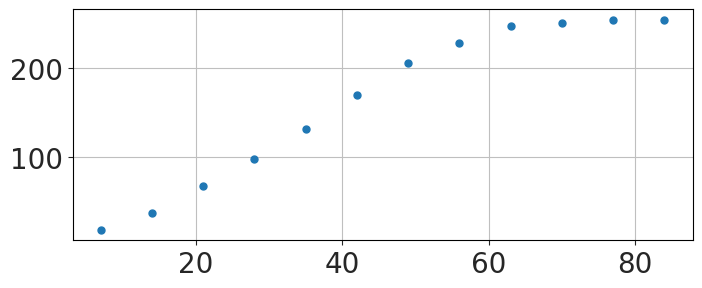

In [ ]:
t_data=data['t'].values
y_data=data['h'].values

figure(figsize=(8,3))
plot(t_data, y_data, 'o')

In [ ]:
from pyndamics3 import Simulation
from pyndamics3.fit import fit,Parameter

pyndamics3  version  0.0.36


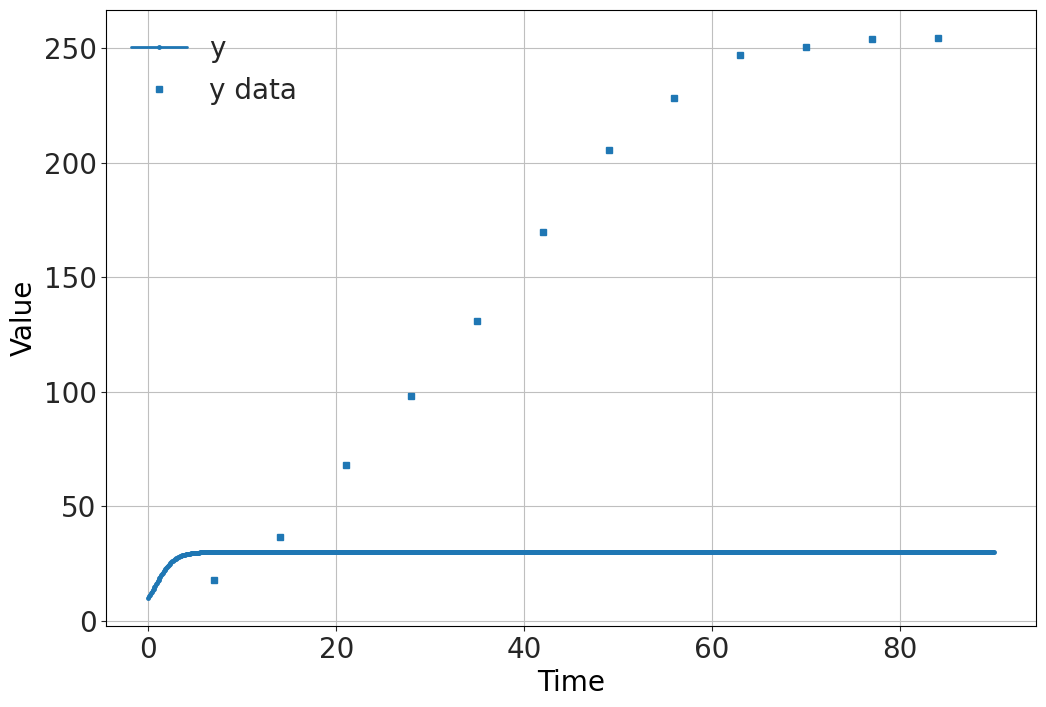

<Figure size 1200x800 with 0 Axes>

In [ ]:
sim=Simulation()
sim.add("y'=a*y*(1-y/K)",initial_value=10,plot=True)
sim.params(a=1,K=30)
sim.add_data(t=t_data,y=y_data,plot=True)
sim.run(90)

In [ ]:
results=fit(sim,
           Parameter("a",value=1,min=0),
           Parameter("K",value=30,min=0),
            method='powell'
           )

results

In [ ]:
def logprior(a,K,initial_y,σ):
    value=0. 
    
    value+=logUniform(a,0,1)
    value+=logNormal(K,100,100,all_positive=True)
    value+=logNormal(initial_y,100,100,all_positive=True)
    value+=logJeffreys(σ)
    
    return value

def loglikelihood(sim,a,K,initial_y,σ):
    # pyndamics already has the data in the Simulation object
    err=sim.err(a=a,K=K,initial_y=initial_y)
    return logNormal(err,0,σ)


In [ ]:
model=MCMCModel(sim,loglikelihood,logprior)

Sampling Prior...
Done.
0.34 s
Running MCMC 1/3...
Done.
7.97 s
Running MCMC 2/3...
Done.
9.39 s
Running MCMC 3/3...
Done.
9.60 s
Copying best estimates to simulation...done.


<Figure size 1200x800 with 0 Axes>

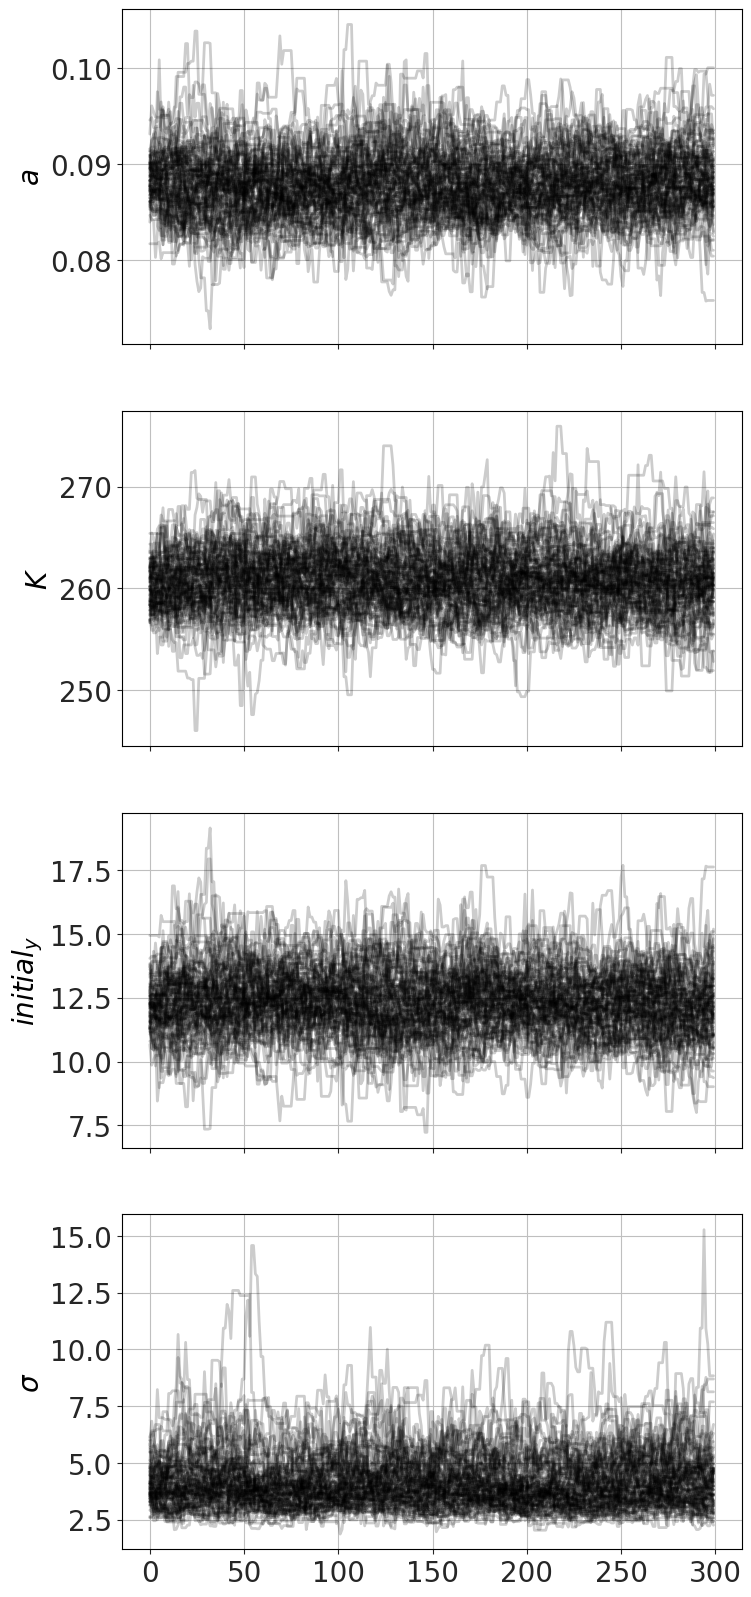

In [ ]:
model.run_mcmc(300,repeat=3,verbose=True)
model.plot_chains()

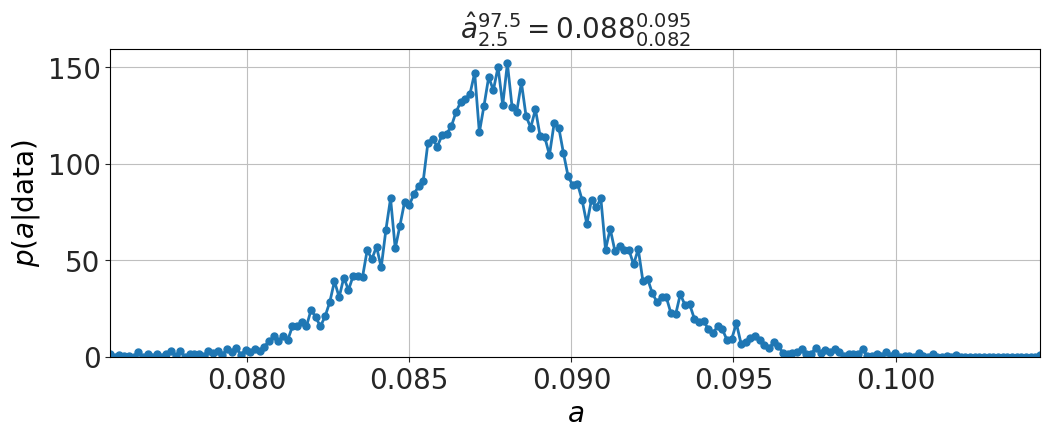

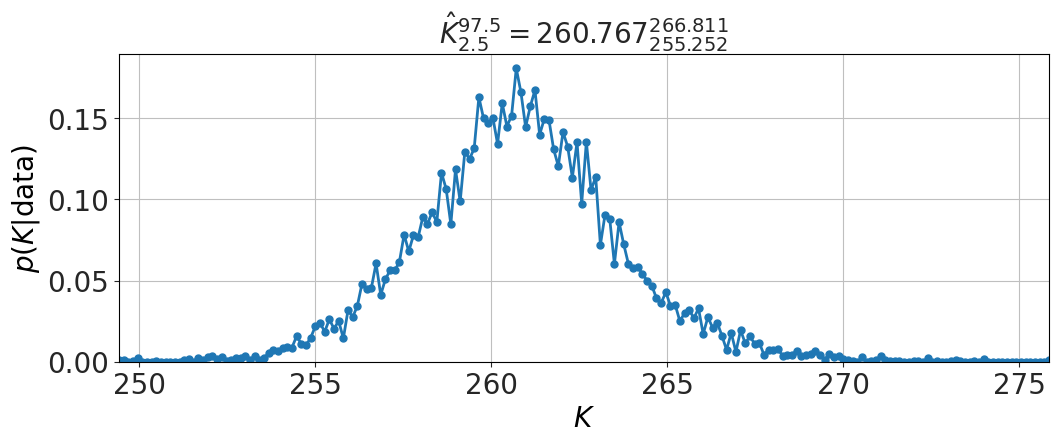

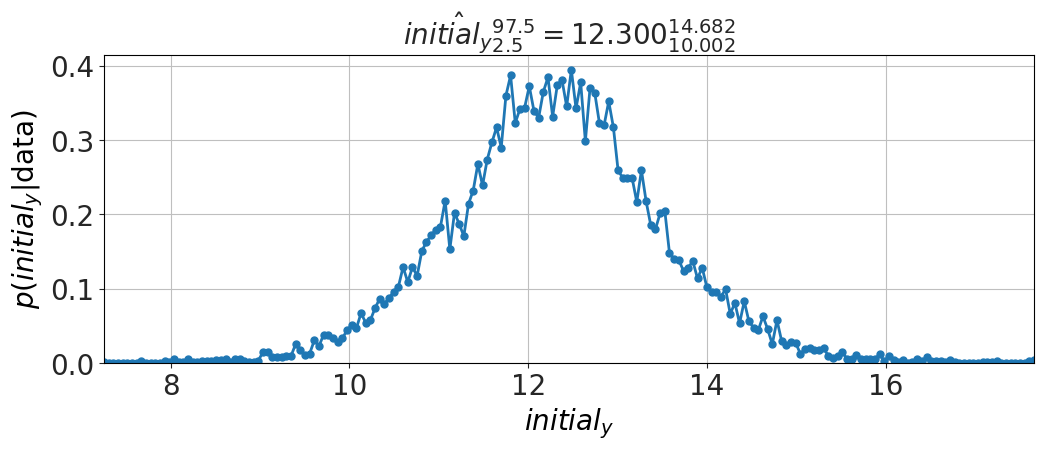

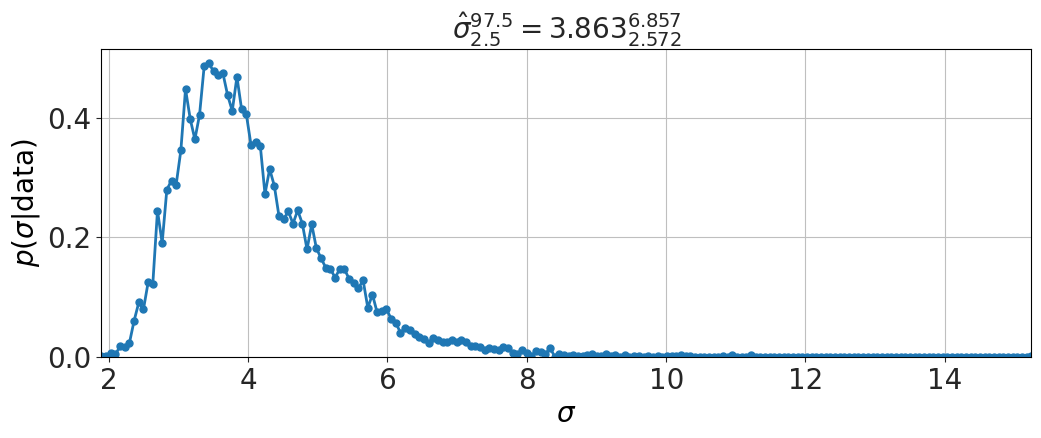

In [ ]:
model.plot_distributions()

In [ ]:
import matplotlib.pyplot as py

In [ ]:
model.sim

<pyndamics3.core.Simulation>

In [ ]:
def plot_many(model,variables,t_min=0,t_max=90,N=300,alpha=0.1):
    if isinstance(variables,str):
        variables=[variables]
    sim=model.sim

    samples=model.get_samples()
    sim.noplots=True  # turn off the simulation plots
    for i in range(N):

        L=samples.shape[0]
        single_sample=samples[np.random.randint(L),:]
        p={}
        for k,key in enumerate(model.keys):
            p[key]=single_sample[k]    

        sim.params(**p)
        sim.run(t_min,t_max)

        for num,p in enumerate(variables):
            t=sim.t
            v=sim[p]
            py.figure(num+1)
            py.plot(t,v,'g-',alpha=alpha)

    median_values=model.percentiles(50)                
    sim.params(**median_values)
    sim.run(t_min,t_max)
    for num,p in enumerate(variables):
        t=sim.t
        v=sim[p]
        py.figure(num+1)
        py.plot(t,v,'b-')

    sim.noplots=False  # gotta love a double-negative
    for num,p in enumerate(variables):
        py.figure(num+1)
        c=sim.get_component(p)
        py.ylabel(c.label)
        py.xlabel('time')
        if not c.data:
            continue
        t=c.data['t']
        v=c.data['value']
        py.plot(t,v,'bo')  


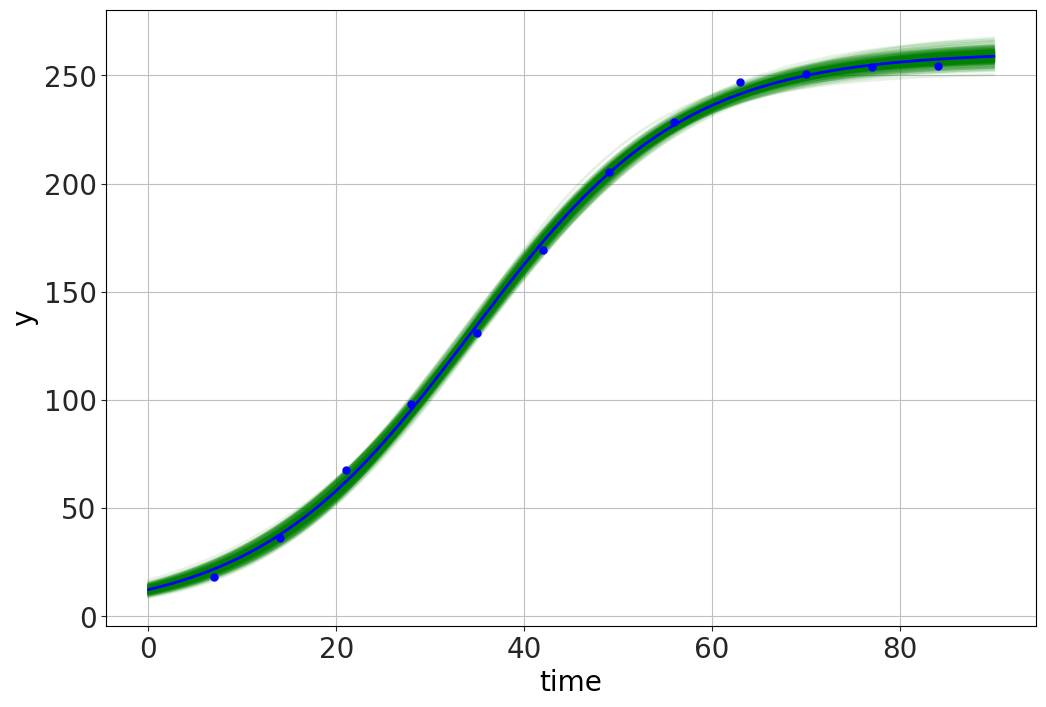

In [ ]:
plot_many(model,'y',t_min=0,t_max=90,N=300)

## Just for debugging, do the same but don't fit the initial value

In [ ]:
def logprior(a,K,σ):
    value=0. 
    
    value+=logUniform(a,0,1)
    value+=logNormal(K,100,100,all_positive=True)
    value+=logJeffreys(σ)
    
    return value

def loglikelihood(sim,a,K,σ):
    # pyndamics already has the data in the Simulation object
    err=sim.err(a=a,K=K)
    return logNormal(err,0,σ)


In [ ]:
model=MCMCModel(sim,loglikelihood,logprior)

Sampling Prior...
Done.
0.25 s
Running MCMC 1/3...
Done.
8.87 s
Running MCMC 2/3...
Done.
9.39 s
Running MCMC 3/3...
Done.
9.27 s
Copying best estimates to simulation...done.


<Figure size 1200x800 with 0 Axes>

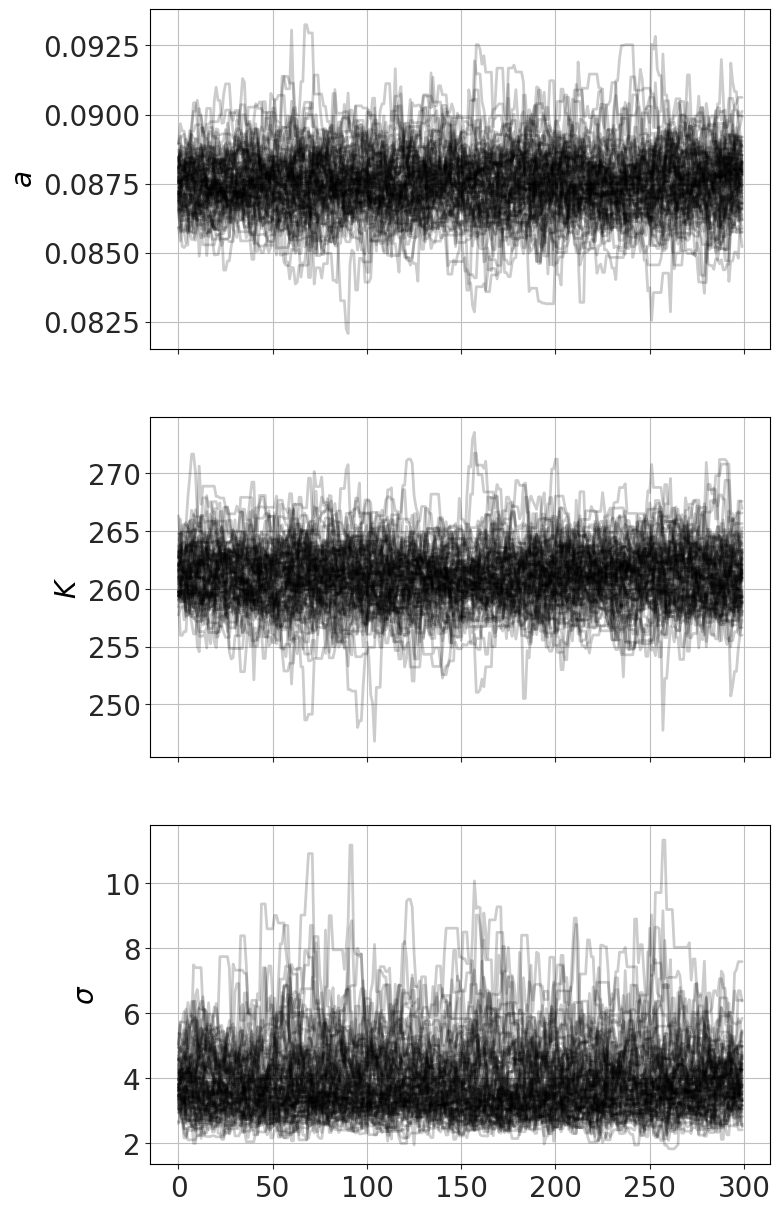

In [ ]:
model.run_mcmc(300,repeat=3,verbose=True)
model.plot_chains()

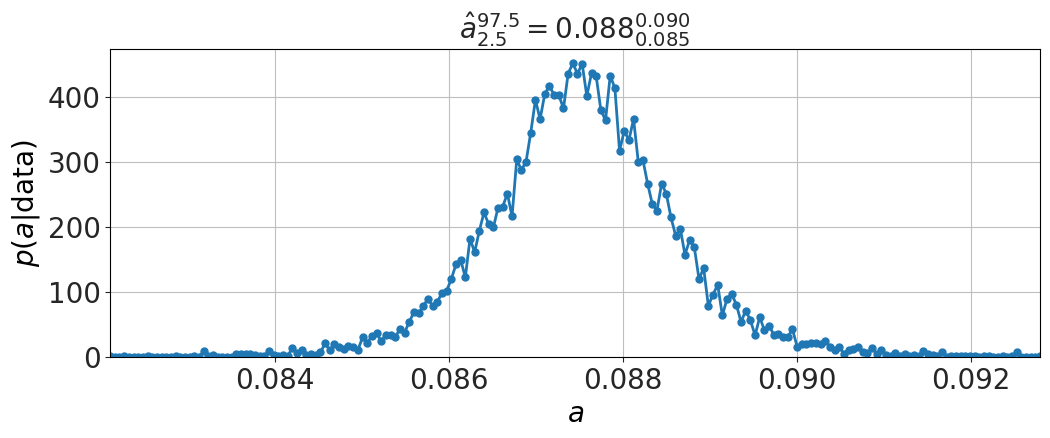

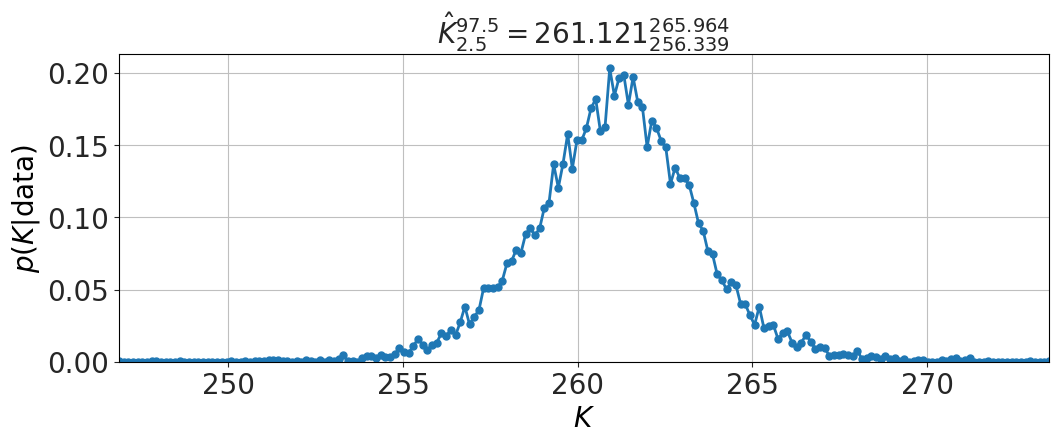

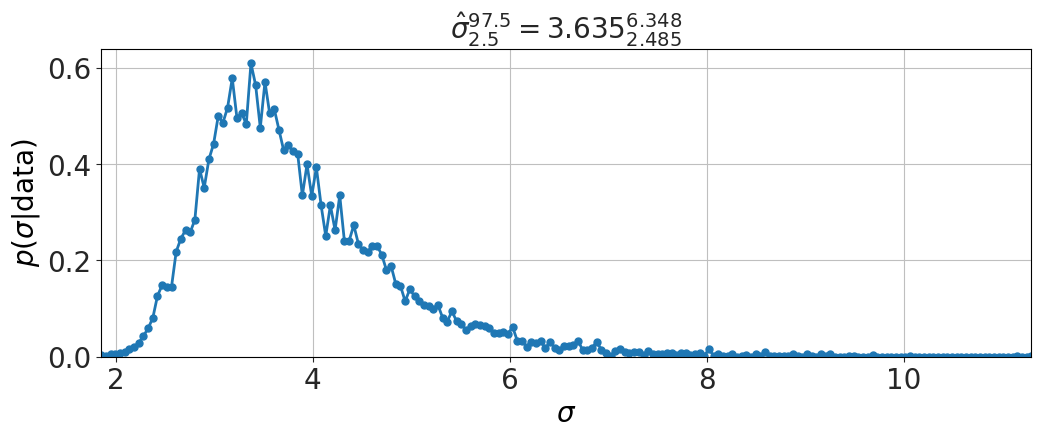

In [ ]:
model.plot_distributions()